# Ant system implementation

Author : Jose Daniel Lopez Hernandez
mail   : A01114386@itesm.mx
date   : November 3, 2023

In [1]:
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
import tsplib95
from lk_heuristic.utils.solver_funcs import solve

# Creation of the graph, node, and ant classes

I decided to implement my own classes for this to be able to easily alter the AS code to accomodate

In [2]:
class Graph:

  """
  def __init__(self, n:int):
    self.n = n
    self.nodes = [Node("N0",[], [])]
    for i in range(1,n):
      connections = []
      weights = []
      exclusion = [i]
      for j in range(len(self.nodes)):
        weight = random.randint(1,10)
        weights.append(weight)
        connections.append(self.nodes[j])
      newNode = Node("N" + str(i), connections, weights)
      self.nodes.append(newNode)
      for j in range(len(connections)):
        connections[j].addConnection(newNode, weights[j])
  """      
  def __init__(self, problem):
    if (problem == None):
        self.nodes = []
        self.n = 0
        return
    self.n = problem.dimension
    self.nodes = []
    for i in range(0,self.n):
        self.nodes.append(Node("N"+str(i),[],[]))
    for i in range(0,self.n):
        connections = []
        weights = []
        for j in range(0,self.n):
            edge = i+1, j+1
            if (i==j): continue
            connections.append(self.nodes[j])
            weights.append(problem.get_weight(*edge))
        self.nodes[i].connections = connections
        self.nodes[i].weights = weights

  def separate(self, size):
      partitionsSize = len(self.nodes)/size
      partitions = []
      for i in range(int(partitionsSize) + 1):
          partition = self.nodes[i*size:((i+1)*size)]
          for j in range(len(partition)):
            partition[j].connections = list(map(lambda x: x if (x in partition) else None, partition[j].connections))
            partition[j].weights = list(map(lambda x, y: x if not(y == None) else None, partition[j].weights, partition[j].connections))
            partition[j].connections = [k for k in partition[j].connections if k is not None]
            partition[j].weights = [k for k in partition[j].weights if k is not None]
          m = Graph(None)
          m.nodes = partition
          partitions.append(m)
      return partitions, int(partitionsSize) + 1

  def show(self):
    for i, val in enumerate(self.nodes):
      nodes = []
      for j, val2 in enumerate(val.connections):
        nodes.append([val2.name, val.weights[j]])
      print(val.name, nodes)



class Node:
  def __init__(self, name, connections, weights):
    self.name = name
    self.connections = connections
    self.weights = weights

  def addConnection(self, node, weight):
    self.connections.append(node)
    self.weights.append(weight)

  def __str__(self):
    return self.name

class Ant:
  def __init__(self, pos):
    self.pos = pos
    self.route = [pos]
    self.cost = 0


### Problem adaptation from TSP instances

In [3]:
problem = tsplib95.load("bier127.tsp")
graph2 = Graph(problem)

graph2.show()

problem = tsplib95.load("eil76.tsp")
graph3 = Graph(problem)

problem = tsplib95.load("eil51.tsp")
graph4 = Graph(problem)


N0 [['N1', 656], ['N2', 1556], ['N3', 1353], ['N4', 1661], ['N5', 991], ['N6', 418], ['N7', 1874], ['N8', 1397], ['N9', 1233], ['N10', 1276], ['N11', 1044], ['N12', 844], ['N13', 883], ['N14', 836], ['N15', 259], ['N16', 1476], ['N17', 2133], ['N18', 1612], ['N19', 1148], ['N20', 1561], ['N21', 1416], ['N22', 1402], ['N23', 1249], ['N24', 3322], ['N25', 2285], ['N26', 1774], ['N27', 3764], ['N28', 3793], ['N29', 1453], ['N30', 1628], ['N31', 4114], ['N32', 3528], ['N33', 1888], ['N34', 1166], ['N35', 1038], ['N36', 883], ['N37', 2320], ['N38', 2133], ['N39', 1724], ['N40', 1069], ['N41', 2320], ['N42', 1649], ['N43', 2167], ['N44', 2499], ['N45', 4153], ['N46', 3269], ['N47', 3536], ['N48', 3603], ['N49', 1050], ['N50', 1069], ['N51', 2091], ['N52', 3412], ['N53', 2065], ['N54', 3267], ['N55', 1982], ['N56', 1640], ['N57', 2625], ['N58', 3236], ['N59', 2678], ['N60', 2698], ['N61', 2865], ['N62', 9305], ['N63', 2708], ['N64', 5834], ['N65', 3396], ['N66', 2678], ['N67', 3603], ['N68', 

### Manual creation of graphs of n nodes

In [4]:
#graph1 = Graph(30)

#graph1.show()

### Ant system implementation for Ant Colony Optimization

General algorithm taken from class slides

Formulas taken from class slides but confirmed through the use of papers and articles (shown in paper)

In [5]:
from logging import exception
def AntColony(ants, generations, graph, a, rho, beta, Q):
  alpha = a
  evap_rate = rho
  cost_mat = []
  ## initialize pheromone matrix
  pheromone_matrix = init_pher(graph)
  ## initialize generation counter
  t = 0

  best = Ant(graph.nodes[0])
  best.cost = 100000000000000000
  while t<generations:
    ## initialize ants in [position0, empty route, 0 cost]
    ant_matrix = []
    for i in range(ants):
      ant_matrix.append(Ant(graph.nodes[0]))
    ## Ant route calculations
    for i in range(ants):
      for j in range(len(graph.nodes)):
        if (j == len(graph.nodes)-1):
            ant_matrix[i].route.append(ant_matrix[i].pos.connections[0])
            ant_matrix[i].cost += ant_matrix[i].pos.weights[0]
            ant_matrix[i].pos = ant_matrix[i].route[-1]
            break
        p = random.uniform(0,1)
        pos = int(ant_matrix[i].pos.name.split("N")[-1])
        phero = list(map(lambda x : (x**alpha)  , pheromone_matrix[pos]))
        heuristic = list(map(lambda x : (1/(x+.000000001))**beta, graph.nodes[pos].weights))
        s = sum(list(map(lambda x, y: x*y, phero, heuristic)))
        zipped = list(zip(pheromone_matrix[pos], ant_matrix[i].pos.connections, ant_matrix[i].pos.weights))
        random.shuffle(zipped)
        list1, list2, list3= zip(*zipped)
        pheromone, nodes, weights = list(list1), list(list2), list(list3)
        k = 0
        path = -1
        while k < len(nodes):
            pt = ((pheromone[k]**alpha * (1/(weights[k]+.00000001))**beta) / s)
            if(p<pt and not(nodes[k] in ant_matrix[i].route)):
              path = k
              break
            k += 1
        if(path == -1):
          possible_paths = list(map(lambda x: x if not(x in ant_matrix[i].route) else None, ant_matrix[i].pos.connections))
          possible_paths = [k for k in possible_paths if k is not None]
          path = random.randint(0,len(possible_paths)-1)
          ant_matrix[i].route.append(possible_paths[path])
          ant_matrix[i].cost += ant_matrix[i].pos.weights[ant_matrix[i].pos.connections.index(possible_paths[path])]
          ant_matrix[i].pos = possible_paths[path]
          continue
        ant_matrix[i].route.append(nodes[path])
        ant_matrix[i].cost += weights[path]
        ant_matrix[i].pos = ant_matrix[i].route[-1]
    ## Pheromone evaporation
    for i in range(len(pheromone_matrix)):
      for j in range(len(pheromone_matrix[i])):
        pheromone_matrix[i][j] = pheromone_matrix[i][j] * (1-evap_rate)
    ## Pheromone deposit
    for i in range(ants):
      pheromone = Q/(ant_matrix[i].cost)
      for j in range(len(graph.nodes)):
        origin = ant_matrix[i].route[j]
        destiny = ant_matrix[i].route[j+1]
        pos = int(origin.name.split("N")[-1])
        route = origin.connections.index(destiny)
        pheromone_matrix[pos][route] += pheromone
        if (pheromone_matrix[pos][route] > 1): pheromone_matrix[pos][route] = 1

    t += 1
    x = list(map(lambda x : x.cost, ant_matrix))
    x = x.index(min(x))
    route = list(map(lambda x : x.name, ant_matrix[x].route))
    """
    print("Generation ",t, " Complete, Best route: \n")
    print(ant_matrix[x].cost, route, "\n")
    """
    if(best.cost > ant_matrix[x].cost):
      best = ant_matrix[x]

    cost_mat.append(best.cost)

  return best, cost_mat

Decided to instantiate matrix with x > 0 to avoid division by 0 problems.

In [6]:
def init_pher(graph):
  pheromones = []
  for i in range(len(graph.nodes)):
    pheromones.append([])
    for j in range(len(graph.nodes[i].connections)):
        pheromones[i].append(1)

  return pheromones

### TSP Brute forcer

In [7]:
from sys import maxsize
from itertools import permutations

# implementation of traveling Salesman Problem
def travellingSalesmanProblem(graphObject):
    V = len(graphObject.nodes)
    graph = []
    for i in range(len(graphObject.nodes)):
      graph.append([])
      for j in range(len(graphObject.nodes[i].connections)):
        graph[i].append(graphObject.nodes[i].weights[j])
      graph[i].insert(i, 0)

    #print(graph)
    s = 0


    # store all vertex apart from source vertex
    vertex = []
    for i in range(V):
        if i != s:
            vertex.append(i)

    # store minimum weight Hamiltonian Cycle
    min_path = maxsize
    next_permutation=permutations(vertex)
    for i in next_permutation:

        # store current Path weight(cost)
        current_pathweight = 0

        # compute current path weight
        k = s
        for j in i:
            current_pathweight += graph[k][j]
            k = j
        current_pathweight += graph[k][s]

        # update minimum
        min_path = min(min_path, current_pathweight)

    return min_path



## Algorithm runner

Last result shows the best result in the execution of 

Generation  0 finished
Generation  1 finished
Generation  2 finished
142023 163677 93218.0 ['N0', 'N15', 'N36', 'N35', 'N34', 'N39', 'N42', 'N33', 'N38', 'N41', 'N37', 'N25', 'N26', 'N30', 'N29', 'N40', 'N13', 'N107', 'N5', 'N105', 'N104', 'N113', 'N10', 'N8', 'N2', 'N9', 'N119', 'N6', 'N1', 'N50', 'N4', 'N120', 'N123', 'N51', 'N49', 'N12', 'N114', 'N56', 'N53', 'N44', 'N102', 'N48', 'N52', 'N117', 'N47', 'N93', 'N45', 'N110', 'N111', 'N46', 'N55', 'N99', 'N57', 'N63', 'N90', 'N60', 'N61', 'N59', 'N115', 'N89', 'N58', 'N66', 'N7', 'N71', 'N18', 'N21', 'N3', 'N22', 'N23', 'N14', 'N19', 'N20', 'N16', 'N76', 'N17', 'N72', 'N73', 'N67', 'N70', 'N69', 'N68', 'N74', 'N75', 'N77', 'N116', 'N83', 'N80', 'N125', 'N81', 'N82', 'N101', 'N100', 'N62', 'N118', 'N95', 'N108', 'N87', 'N86', 'N85', 'N84', 'N109', 'N103', 'N124', 'N88', 'N91', 'N98', 'N64', 'N112', 'N65', 'N54', 'N43', 'N11', 'N78', 'N79', 'N24', 'N32', 'N121', 'N27', 'N28', 'N31', 'N97', 'N96', 'N122', 'N94', 'N92', 'N126', 'N106', 'N

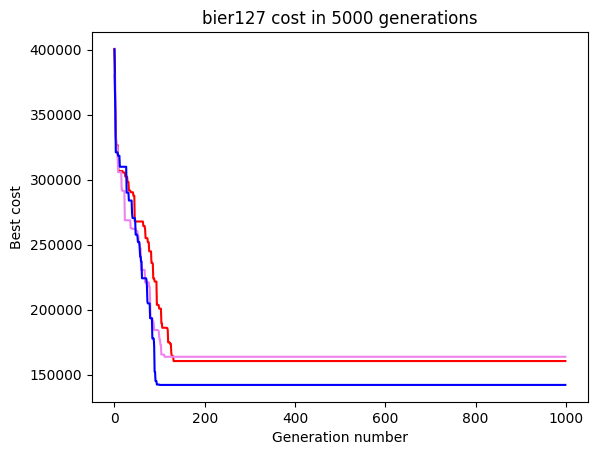

In [10]:
worse = 0
best = 10000000
route = []
total = 0
graphs = []
alpha = [1,2,5,1,1,1,1,5,.5]
beta = [1,1,1,2,5,1,1,5,.5]
rho = [0,0,0,0,0,.2,.5,.5,0]
gen = 3
for i in range(gen):
  k, graph = AntColony(31,1000,graph2, 2, .99, 5, 100)
  total += k.cost
  if k.cost < best:
    route = list(map(lambda x : x.name, k.route))
    best = k.cost
  if k.cost > worse:
    worse = k.cost
  graphs.append(graph)
  print("Generation ",i, "finished")

print(best, worse, total/5, route)
colors =["red", "violet", "blue", "green", "silver", "gold", "orange", "black", "cyan", "yellow"]
plt.title("bier127 cost in 5000 generations")
plt.xlabel("Generation number")
plt.ylabel("Best cost")
legends = []
for i in range(gen):
    legends.append("a:" + str(alpha[i]) + " b:" + str(beta[i]) + " p:" + str(rho[i]))
    plt.plot(graphs[i], c = colors[i])
    

#plt.legend(legends, loc='upper right')


In [9]:
solve(tsp_file="bier127.tsp", solution_method="lk1_improve", runs=30, backtracking=(5, 5), reduction_level=4, reduction_cycle=4, tour_type="cycle", file_name="C:solution", logging_level=20)

2023-11-13 21:11:30,995 [INFO] lk_heuristic.utils.solver_funcs: Importing .tsp file 'bier127.tsp'
2023-11-13 21:11:30,998 [INFO] lk_heuristic.utils.solver_funcs: Using 'euc_2d' for edge type 'EUC_2D'
2023-11-13 21:11:31,001 [INFO] lk_heuristic.utils.solver_funcs: Creating TSP instance
2023-11-13 21:11:31,047 [INFO] lk_heuristic.utils.solver_funcs: Starting improve loop
2023-11-13 21:11:31,756 [INFO] lk_heuristic.utils.solver_funcs: [Run:1] --> Cost: 123348.806 / Best: 123348.806 / Mean: 123348.806 (0.706s)
2023-11-13 21:11:32,226 [INFO] lk_heuristic.utils.solver_funcs: [Run:2] --> Cost: 123817.756 / Best: 123348.806 / Mean: 123583.281 (0.467s)
2023-11-13 21:11:33,108 [INFO] lk_heuristic.utils.solver_funcs: [Run:3] --> Cost: 125867.099 / Best: 123348.806 / Mean: 124344.553 (0.881s)
2023-11-13 21:11:34,110 [INFO] lk_heuristic.utils.solver_funcs: [Run:4] --> Cost: 122186.356 / Best: 122186.356 / Mean: 123805.004 (1.000s)
2023-11-13 21:11:35,340 [INFO] lk_heuristic.utils.solver_funcs: [Run

ValueError: too many values to unpack (expected 5)

In [ ]:
#134314 154118 88022.0

Generation  0 finished
Generation  1 finished
Generation  2 finished
Generation  3 finished
Generation  4 finished
508 588 543.4 ['N0', 'N31', 'N10', 'N37', 'N4', 'N11', 'N16', 'N36', 'N43', 'N14', 'N44', 'N32', 'N9', 'N48', 'N8', 'N49', 'N15', 'N28', 'N20', 'N33', 'N29', 'N38', 'N50', 'N45', 'N46', 'N17', 'N3', 'N18', 'N40', 'N41', 'N39', 'N12', 'N24', 'N13', 'N5', 'N26', 'N47', 'N42', 'N23', 'N22', 'N6', 'N25', 'N7', 'N27', 'N30', 'N35', 'N34', 'N19', 'N2', 'N21', 'N1', 'N0']


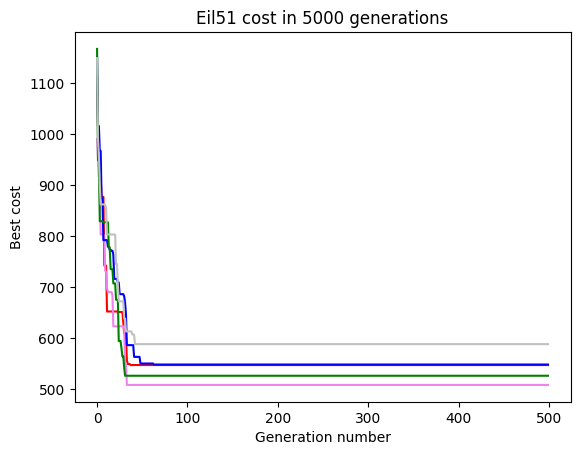

In [11]:
worse = 0
best = 10000000
route = []
total = 0
graphs = []
alpha = [1,2,5,1,1,1,1,5,.5]
beta = [1,1,1,2,5,1,1,5,.5]
rho = [0,0,0,0,0,.2,.5,.5,0]
gen = 5
for i in range(gen):
  k, graph = AntColony(13,500,graph4, 2, .9, 5, 100)
  total += k.cost
  if k.cost < best:
    route = list(map(lambda x : x.name, k.route))
    best = k.cost
  if k.cost > worse:
    worse = k.cost
  graphs.append(graph)
  print("Generation ",i, "finished")

print(best, worse, total/5, route)
colors =["red", "violet", "blue", "green", "silver", "gold", "orange", "black", "cyan", "yellow"]
plt.title("Eil51 cost in 5000 generations")
plt.xlabel("Generation number")
plt.ylabel("Best cost")
legends = []
for i in range(gen):
    #legends.append("a:" + str(alpha[i]) + " b:" + str(beta[i]) + " p:" + str(rho[i]))
    plt.plot(graphs[i], c = colors[i])
    

#plt.legend(legends, loc='upper right')

Generation  0 finished
Generation  1 finished
Generation  2 finished
Generation  3 finished
Generation  4 finished
613 698 660.0 ['N0', 'N72', 'N61', 'N27', 'N73', 'N29', 'N47', 'N46', 'N35', 'N70', 'N59', 'N69', 'N36', 'N19', 'N4', 'N14', 'N56', 'N12', 'N26', 'N51', 'N33', 'N45', 'N7', 'N53', 'N18', 'N34', 'N6', 'N52', 'N13', 'N58', 'N10', 'N65', 'N37', 'N64', 'N57', 'N71', 'N38', 'N8', 'N31', 'N43', 'N2', 'N39', 'N11', 'N25', 'N66', 'N75', 'N74', 'N3', 'N44', 'N28', 'N20', 'N68', 'N60', 'N21', 'N42', 'N40', 'N41', 'N63', 'N22', 'N55', 'N48', 'N23', 'N17', 'N49', 'N24', 'N54', 'N30', 'N9', 'N16', 'N50', 'N5', 'N67', 'N1', 'N32', 'N15', 'N62', 'N0']


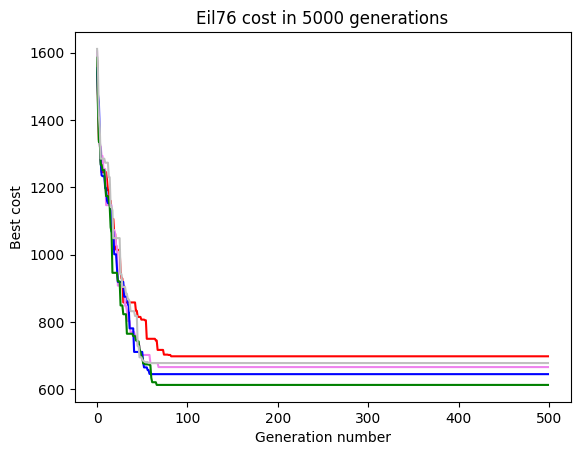

In [12]:
worse = 0
best = 10000000
route = []
total = 0
graphs = []
alpha = [1,2,5,1,1,1,1,5,.5]
beta = [1,1,1,2,5,1,1,5,.5]
rho = [0,0,0,0,0,.2,.5,.5,0]
gen = 5
for i in range(gen):
  k, graph = AntColony(20,500,graph3, 2, .9, 5, 100)
  total += k.cost
  if k.cost < best:
    route = list(map(lambda x : x.name, k.route))
    best = k.cost
  if k.cost > worse:
    worse = k.cost
  graphs.append(graph)
  print("Generation ",i, "finished")

print(best, worse, total/5, route)
colors =["red", "violet", "blue", "green", "silver", "gold", "orange", "black", "cyan", "yellow"]
plt.title("Eil76 cost in 5000 generations")
plt.xlabel("Generation number")
plt.ylabel("Best cost")
legends = []
for i in range(gen):
    #legends.append("a:" + str(alpha[i]) + " b:" + str(beta[i]) + " p:" + str(rho[i]))
    plt.plot(graphs[i], c = colors[i])
    

#plt.legend(legends, loc='upper right')

In [ ]:
solve(tsp_file="eil76.tsp", solution_method="lk1_improve", runs=30, backtracking=(5, 5), reduction_level=4, reduction_cycle=4, tour_type="cycle", file_name="C:solution", logging_level=20)

In [ ]:
solve(tsp_file="eil51.tsp", solution_method="lk1_improve", runs=30, backtracking=(5, 5), reduction_level=4, reduction_cycle=4, tour_type="cycle", file_name="C:solution", logging_level=20)